In [1]:
import os
from tqdm import tqdm
import xarray
import pandas as pd
import geopandas as gpd
from datetime import date, timedelta
from scipy.stats import pearsonr
import spotpy
from scipy import stats

import cartopy.feature as cfeature
import numpy as np
import cartopy.crs as ccrs
import cartopy
import colorcet as cc
from cmcrameri import cm
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import proplot as pplt
import xarray 
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from scipy.optimize import curve_fit


plt.rcParams['figure.autolayout'] = True 
plt.rcParams.update({'font.size': 12}) 
SAVE_KWDS = {"bbox_inches": "tight", "dpi": 450, "facecolor": "w"}
BASE_PLOT = {"facecolor": 'none', "edgecolor": 'k', "alpha": 0.9,}#  "figsize": (4, 4)}

#warning
import warnings
warnings.filterwarnings('ignore')



In [2]:
#############################################################
#os.chdir('D:/XanthosDev/Results_11072021/94')
#os.chdir('D:/XanthosDev/Results_11072021/Result_100k')
basinName = pd.read_csv('D:/XanthosDev/example/input/reference/BasinNames235.txt')
basin_id = pd.read_csv('D:/XanthosDev/example/input/reference/basin.csv')
#GRDC_xanthosCoordIndx = pd.read_csv('/project/hli/gabeshu/Guta_Working/Basins_Result/UScells/inputs/GRDC_xanthosCoordIndx.csv')
GRDC_xanthosCoordIndx = pd.read_csv('D:/XanthosDev/example/input/GRDC_stations_selected_final_list.csv')

indx_f = ~((GRDC_xanthosCoordIndx['basins']==58) | (GRDC_xanthosCoordIndx['basins']==84) | (GRDC_xanthosCoordIndx['basins']==169))
GRDC_xanthosCoordIndx = GRDC_xanthosCoordIndx[indx_f].reset_index(drop=True)

basins94 = np.array(GRDC_xanthosCoordIndx['basins']).astype(np.int64)
xanthosid = np.array(GRDC_xanthosCoordIndx['xanthosID_new_adj']).astype(np.int64)
basinName_94 = []
for ii in range(91):
    indx_basin = basins94[ii] - 1
    basinName_94.append(basinName['BName'][indx_basin])


In [3]:
def runoff_model_output(dir_in, basin_num):
    os.chdir(dir_in)
    basin_calibration =  pd.read_csv('basin_calibration_' + str(basin_num) + 'c.csv')
    basin_calibration = basin_calibration.drop(['para',	'parb',	'parc',	'pard',	'parm'], 1)
    ## basin_abcd
    basin_abcd = basin_calibration[['simulation1_1', 'simulation1_2', 'simulation1_3', 'simulation1_4', 'simulation1_5']]
    basin_abcd.columns = ['par_a',	'par_b',	'par_c',	'par_d',	'par_m']
    basin_calibration = basin_calibration.drop(['simulation1_1', 'simulation1_2', 'simulation1_3', 'simulation1_4', 'simulation1_5'], 1)

    ######### Runoff
    ## basin annual runoff
    basin_annaul_RO  = basin_calibration[['simulation2_1', 'simulation2_2', 'simulation2_3',
                                            'simulation2_4', 'simulation2_5', 'simulation2_6', 'simulation2_7',
                                            'simulation2_8', 'simulation2_9', 'simulation2_10', 'simulation2_11',
                                            'simulation2_12', 'simulation2_13', 'simulation2_14', 'simulation2_15',
                                            'simulation2_16', 'simulation2_17', 'simulation2_18', 'simulation2_19',
                                            'simulation2_20', 'simulation2_21', 'simulation2_22', 'simulation2_23',
                                            'simulation2_24', 'simulation2_25', 'simulation2_26', 'simulation2_27',
                                            'simulation2_28', 'simulation2_29', 'simulation2_30', 'simulation2_31']]
    basin_annaul_RO.columns = np.arange(1971,2002, 1)   
    ## basin mean monthly runoff
    basin_MM_RO   = basin_calibration[['simulation3_1', 'simulation3_2', 'simulation3_3', 'simulation3_4',
                                        'simulation3_5', 'simulation3_6', 'simulation3_7', 'simulation3_8',
                                        'simulation3_9', 'simulation3_10', 'simulation3_11', 'simulation3_12']]
    basin_MM_RO.columns  = [['Ja', 'Fb', 'Mr', 'Ap', 'My', 'Ju', 'Jl', 'Ag', 'Sb', 'Oc', 'Nv', 'Dc']]


    ######## ET
    ## basin annual ET
    basin_annaul_ET  = basin_calibration[['simulation4_1', 'simulation4_2', 'simulation4_3', 'simulation4_4',
                                            'simulation4_5', 'simulation4_6', 'simulation4_7', 'simulation4_8',
                                            'simulation4_9', 'simulation4_10', 'simulation4_11', 'simulation4_12',
                                            'simulation4_13', 'simulation4_14', 'simulation4_15', 'simulation4_16',
                                            'simulation4_17', 'simulation4_18', 'simulation4_19', 'simulation4_20',
                                            'simulation4_21', 'simulation4_22', 'simulation4_23', 'simulation4_24',
                                            'simulation4_25', 'simulation4_26', 'simulation4_27', 'simulation4_28',
                                            'simulation4_29', 'simulation4_30', 'simulation4_31']]
    basin_annaul_ET.columns = np.arange(1971,2002, 1)   

    ## basin mean monthly ET
    basin_MM_ET   = basin_calibration[['simulation5_1','simulation5_2', 'simulation5_3', 'simulation5_4', 'simulation5_5',
                    'simulation5_6', 'simulation5_7', 'simulation5_8', 'simulation5_9',
                    'simulation5_10', 'simulation5_11', 'simulation5_12']]
    basin_MM_ET.columns  = [['Ja', 'Fb', 'Mr', 'Ap', 'My', 'Ju', 'Jl', 'Ag', 'Sb', 'Oc', 'Nv', 'Dc']]

    return basin_abcd, basin_annaul_RO, basin_MM_RO, basin_annaul_ET, basin_MM_ET


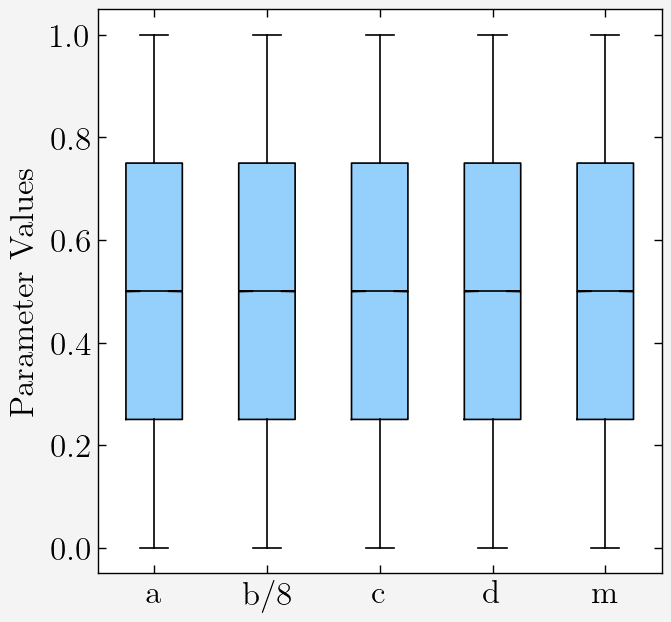

In [4]:
start_yr = 1971
ending_yr = 1990
dir_in = 'D:\\XanthosDev\\Parameter-Selection\\WATCH\\WATCH-1M-Run-abcdm'
SAVE_KWDS = {"bbox_inches": "tight", "dpi": 450, "facecolor": "w"}
length_check = np.zeros([91,])
plt.rcParams['figure.autolayout'] = True 
plt.rcParams.update({'font.size': 12}) 

basin_num = 6
bb = np.where(basins94==basin_num)[0]
## Get data : simulated   
basin_abcd, basin_annaul_RO, basin_MM_RO, basin_annaul_ET, basin_MM_ET = runoff_model_output(dir_in, basin_num)
basin_abcd['par_b'] = basin_abcd['par_b']/8
basin_abcd.columns = ['a','b','c','d','m']
##################################################
plt.style.use('science')
with plt.style.context(['science', 'high-contrast']):
    fig, axs = pplt.subplots(nrows=1, ncols=1,  share=1, journal='pnas1')
    ax = axs[0]
    ax.boxplot(np.array(basin_abcd), notch=True ,facecolor='light blue')


    ax.set_xticklabels(['a','b/8','c','d','m'])
    #ax.autoscale(tight=True)      
    ax.format(ylabel='Parameter Values' , fontsize= 12)  
    ax.format(ylabel='Parameter Values', abcstyle=False,  grid=False)   
    ax.minorticks_off()

plt.tight_layout()   

fgiure_dir = 'C:\\Users\\gwabeshu.COUGARNET\\OneDrive - University Of Houston\\Desktop\\Xanthos-Manuscript\\figures-v2\\'
plt.savefig(fgiure_dir + "Figure-5-LHS-sampling-plot.png", **SAVE_KWDS)  